In [83]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from model import ode_y, ode_y_jump_approach_one, ode_y_jump_approach_one_boundary
from model import solve_with_emission_boundary
from utilities import find_nearest_value
from numba import njit

import matplotlib as mpl

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

**ODE with predetermined emission**:
\begin{align*}
0 =  &  -\delta \phi(y) + \delta \eta \log \color{blue}{\tilde{e}} \\
&+ \left(\frac{d\phi(y)}{dy}+ (\eta-1)(\gamma_1 + \gamma_2 y)\right)\color{blue}{\tilde{e}}\sum_{i=1}^n \pi_i^c \theta_i\ \\
& + \frac{1}{2} \left(\frac{d^2 \phi(y)}{(d y)^2} + (\eta-1)\gamma_2\right)|\sigma_y|^2(\color{blue}{\tilde{e}})^2\\
\end{align*}

Marginal value of emission:
\begin{align*}
ME =  & - \left(\frac{d\phi(y)}{dy}+ (\eta-1)(\gamma_1 + \gamma_2 y)\right)\sum_{i=1}^n \pi_i^c \theta_i\ \\
& - \left(\frac{d^2 \phi(y)}{(d y)^2} + (\eta-1)\gamma_2\right)|\sigma_y|^2\color{blue}{\tilde{e}}\\
\end{align*}

In [87]:
ξ_1m = 1./400
ξ_2m = 1./20
ξ_a = 1./10000

η = .032
δ = .01

θ = pd.read_csv('../data/model144.csv', header=None).to_numpy()[:, 0]/1000.
πc_o = np.ones_like(θ)/len(θ)
σ_y = 1.2*1.86/1000

y_bar = 2.
γ_1 = 1.7675/10000
γ_2 = .0022*2
# γ_2p = np.array([0, .0197*2])
# γ_2p = np.array([0, .3853*2])
# πd_o = np.array([.5, .5])
γ_2p = np.array([0, .0197*2, .3853*2])
# πd_o = np.array([.475, .475, .05])
πd_o = np.array([1./3, 1./3, 1./3])

y_step = .04
y_grid_long = np.arange(0., 4., y_step)
y_grid_short = np.arange(0., 2+y_step, y_step)
n_bar = find_nearest_value(y_grid_long, y_bar) + 1

# Prepare ϕ
ϕ_list = []
for γ_2p_i in γ_2p:
    model_paras = (η, δ, θ, πc_o, σ_y, ξ_1m, ξ_a, γ_1, γ_2, γ_2p_i, y_bar) 
    model_res = ode_y(y_grid_long, model_paras, v0=None, ϵ=.5,
                       tol=1e-8, max_iter=10_000, print_all=False)
    ϕ_list.append(model_res['v0'])

ϕ_list_short = []
for ϕ_i in ϕ_list:
    temp = ϕ_i[:n_bar]
    ϕ_list_short.append(temp)
ϕ_i = np.array(ϕ_list_short)

# Compute ϕ
ς = .25
model_paras = (η, δ, θ, πc_o, σ_y, ξ_1m, ξ_2m, ξ_a, ς, γ_1, γ_2, y_bar, ϕ_i, πd_o)
model_res = ode_y_jump_approach_one_boundary(y_grid_short, model_paras, v0=np.average(ϕ_i, weights=πd_o, axis=0),
                                                    ϵ=.5, tol=1e-9, max_iter=10000, print_all=False)

Converged. Total iteration 1989: LHS Error: 9.985022919600794e-09; RHS Error 1.6264680024628613e-06
Converged. Total iteration 2081: LHS Error: 9.97927577378599e-09; RHS Error 8.222185655702295e-06
Converged. Total iteration 2313: LHS Error: 9.981253129565104e-09; RHS Error 3.7902347181765796e-05
Converged. Total iteration 837: LHS Error: 9.909596199175752e-10; RHS Error 1.4080793324894791e-05


In [88]:
e_tilde = model_res['e_tilde']

# Compute marginal values for emission (under distorted probabilities)
ME_distorted = δ*η/e_tilde

# Compute marginal values for emission (under baseline probabilities)
model_paras_new = (η, δ, θ, πc_o, σ_y, γ_1, γ_2, ϕ_i, πd_o, e_tilde)
model_res_new = solve_with_emission_boundary(y_grid_short, model_paras_new)

ME_baseline = model_res_new['ME']

Solved. PDE error: 7.895319748849852e-06


Text(0.5, 1.0, 'log difference * 100 * -1')

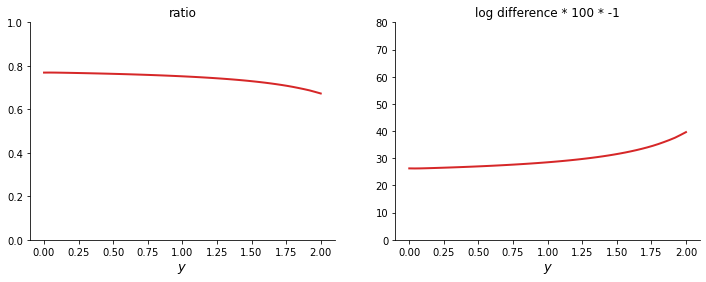

In [89]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,4))
ax1.plot(y_grid_short, ME_baseline/ME_distorted, color='C3', linewidth=2.)
ax1.set_xlabel(r'$y$', fontsize=13)
ax1.set_title('ratio')
ax1.set_ylim(0, 1)

ax2.plot(y_grid_short, -np.log(ME_baseline/ME_distorted)*100, color='C3', linewidth=2.)
ax2.set_xlabel(r'$y$', fontsize=13)
ax2.set_ylim(0, 80)
ax2.set_title('log difference * 100 * -1')

# fig.savefig('fig_ambiguity_damage_averse.pdf')

In [75]:
(ME_baseline/ME_distorted)[-1]

0.7985981208951383